Using data

CO2
                     Lines parsed: 31774
H2O
                     Lines parsed: 23399

Data is fetched from http://hitran.org

BEGIN DOWNLOAD: H2O
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes written to data/H2O.data
  65536 bytes writ

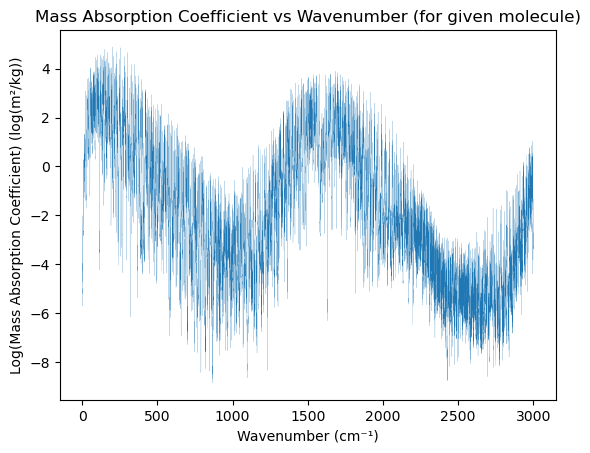

In [173]:
from research_functions import import_HAPI_data  
import numpy as np
from hapi import *
import matplotlib.pyplot as plt

#test
wavenumber_H2O, H2O_log_coefs = import_HAPI_data("H2O",1,1, 0, 3000, .01805)

In [13]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

#train validation test split
X_train, X_temp, y_train, y_temp = train_test_split(wavenumber_H2O, H2O_log_coefs,test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp,test_size=0.66)

# Convert to tensors and reshape (unsqueeze)
X_train = torch.tensor(X_train).float().unsqueeze(1)
y_train = torch.tensor(y_train).float().unsqueeze(1)
X_val = torch.tensor(X_val).float().unsqueeze(1)
y_val = torch.tensor(y_val).float().unsqueeze(1)
X_test = torch.tensor(X_test).float().unsqueeze(1)
y_test = torch.tensor(y_test).float().unsqueeze(1)

# Normalize using training set stats only
x_mean, x_std = X_train.mean(), X_train.std()

X_train = (X_train - x_mean) / x_std
X_val = (X_val - x_mean) / x_std
X_test = (X_test - x_mean) / x_std

In [175]:
#model definition using pytorch
import torch.nn as nn

class SpectralNN(nn.Module):   #to utiize another type of model architecture, jsut define a class similar to this one
    def __init__(self):
        super(SpectralNN,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),  # Input layer: 1 feature → 64 neurons
            nn.LeakyReLU(0.01),         # Activation function
            nn.Linear(64, 64), # Hidden layer: 64 → 64 neurons
            nn.LeakyReLU(0.01),         # Activation function
            nn.Linear(64, 1)   # Output layer: 64 → 1 output
        )

    def forward(self, x):
        return self.model(x)
            

In [73]:
#below we have our first set of hyperparameter tuning

In [67]:
#model training and hyperparameter tuning
learningRates = [1e-4, 5e-4, 1e-3]
num_epochs_list = [200, 500, 1000]

optimal_loss = float('inf') #big intial loss value so it'll update
optimal_hyperparameters = {}

for lr in learningRates: #for loop for all hyperparameters
    for epochs in num_epochs_list:
        model = SpectralNN() #instance of the neural network class we created above
        loss_function = nn.MSELoss()  #a loss function object using mean square error 
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)   #adam optimizer, combines momentum and RMSProp along with what we assume is gradient descent 

        for epoch in range(epochs):
            model.train()  #sets model to training mode, not neccesary for this basic model
            optimizer.zero_grad() #clears out old gradients from last step
            y_pred = model(X_train) #computes predicted values ie forward pass
            loss = loss_function(y_pred, y_train) #computes loss using MSE
            loss.backward() #computes loss gradients for backward pass
            optimizer.step()  #uses backward pass to update model weights

        #validation
        model.eval()
        with torch.no_grad():
            pred_val = model(X_val) #uses model trained to get predicted values
            val_loss = loss_function(pred_val, y_val).item() #calculates loss

        print(f"lr: {lr}, epochs: {epochs}, val_loss: {val_loss:.4f}") #prints it out

        if val_loss < optimal_loss:  #updates best loss for final model training
            optimal_loss = val_loss
            optimal_hyperparameters = {'lr': lr, 'epochs': epochs, 'model': model}

print(f"Best val loss: {optimal_loss:.4f} with params: {optimal_hyperparameters}")


lr: 0.0001, epochs: 200, val_loss: 7.9796
lr: 0.0001, epochs: 500, val_loss: 4.5573
lr: 0.0001, epochs: 1000, val_loss: 3.8838
lr: 0.0005, epochs: 200, val_loss: 4.2652
lr: 0.0005, epochs: 500, val_loss: 2.1834
lr: 0.0005, epochs: 1000, val_loss: 1.9566
lr: 0.001, epochs: 200, val_loss: 2.9224
lr: 0.001, epochs: 500, val_loss: 1.9573
lr: 0.001, epochs: 1000, val_loss: 1.8280
Best val loss: 1.8280 with params: {'lr': 0.001, 'epochs': 1000, 'model': SpectralNN(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)}


In [75]:
#below we have the second set of hyperparameter tuning
#the results of our first tuning revelaed higher epochs and a greater learning rate were more accurate, so I did more tuing with the learning rates to see which is best
#tuning with a higher number of epochs is inefficient due to the increased time needed

In [71]:
#model training and hyperparameter tuning
learningRates = [1e-3, 5e-2, 1e-2, .05, .1]

optimal_loss = float('inf') #big intial loss value so it'll update
optimal_hyperparameters = {}

for lr in learningRates: #for loop for all hyperparameters
        model = SpectralNN() #instance of the neural network class we created above
        loss_function = nn.MSELoss()  #a loss function object using mean square error 
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)   #adam optimizer, combines momentum and RMSProp along with what we assume is gradient descent 

        for epoch in range(1000):
            model.train()  #sets model to training mode, not neccesary for this basic model
            optimizer.zero_grad() #clears out old gradients from last step
            y_pred = model(X_train) #computes predicted values ie forward pass
            loss = loss_function(y_pred, y_train) #computes loss using MSE
            loss.backward() #computes loss gradients for backward pass
            optimizer.step()  #uses backward pass to update model weights

        #validation
        model.eval()
        with torch.no_grad():
            pred_val = model(X_val) #uses model trained to get predicted values
            val_loss = loss_function(pred_val, y_val).item() #calculates loss

        print(f"lr: {lr}, epochs: {epochs}, val_loss: {val_loss:.4f}") #prints it out

        if val_loss < optimal_loss:  #updates best loss for final model training
            optimal_loss = val_loss
            optimal_hyperparameters = {'lr': lr, 'epochs': epochs, 'model': model}

print(f"Best val loss: {optimal_loss:.4f} with params: {optimal_hyperparameters}")


lr: 0.001, epochs: 1000, val_loss: 1.8243
lr: 0.05, epochs: 1000, val_loss: 1.7235
lr: 0.01, epochs: 1000, val_loss: 1.7184
lr: 0.05, epochs: 1000, val_loss: 1.7281
lr: 0.1, epochs: 1000, val_loss: 1.8079
Best val loss: 1.7184 with params: {'lr': 0.01, 'epochs': 1000, 'model': SpectralNN(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)}


In [77]:
#model training
H2O_model1 = SpectralNN() #instance of the neural network class we created above
H2O_loss_function = nn.MSELoss()  #a loss function object using mean square error 
H2O_optimizer = torch.optim.Adam(H2O_model1.parameters(), lr=0.01)   #adam optimizer, combines momentum and RMSProp along with what we assume is gradient descent 

for epoch in range(1000):
    H2O_model1.train()  #sets model to training mode, not neccesary for this basic model

    y_pred = H2O_model1(X_train) #computes predicted values ie forward pass
    H2O_loss = H2O_loss_function(y_pred, y_train) #computes loss using MSE

    H2O_optimizer.zero_grad() #clears out old gradients from last step
    H2O_loss.backward() #computes loss gradients for backward pass
    H2O_optimizer.step()  #uses backward pass to update model weights

    if epoch % 100 == 0:
        print ("Loss at epoch ", epoch , " is ", H2O_loss.item())

Loss at epoch  0  is  12.331866264343262
Loss at epoch  100  is  1.8654898405075073
Loss at epoch  200  is  1.796957015991211
Loss at epoch  300  is  1.775185465812683
Loss at epoch  400  is  1.7706364393234253
Loss at epoch  500  is  1.7599235773086548
Loss at epoch  600  is  1.7690930366516113
Loss at epoch  700  is  1.7602788209915161
Loss at epoch  800  is  1.7502808570861816
Loss at epoch  900  is  1.7610925436019897


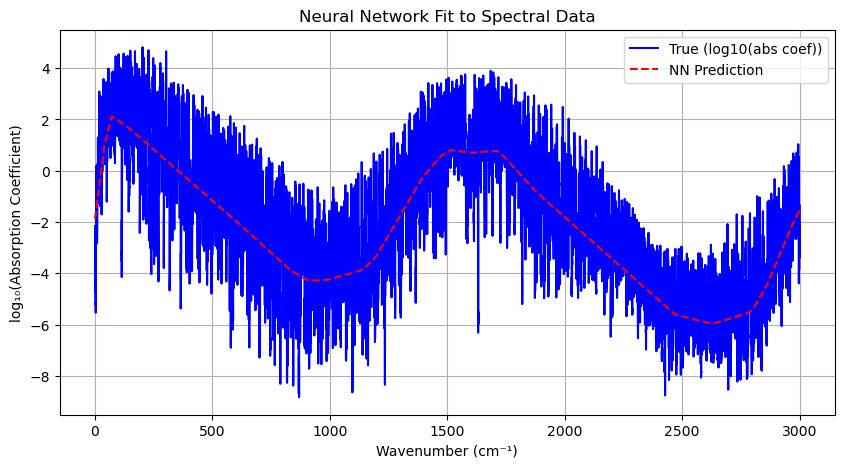

Test Loss (MSE): 1.7690
Test RMSE: 1.3300


In [95]:
#evaluation/plotting fit

H2O_model1.eval()

with torch.no_grad(): #uses torch without gradient since evaluation doesn't need gradients
    y_pred= H2O_model1(X_test)  #gets y_pred for comparision

# Convert tensors to NumPy arrays for plotting
X_test_vals = (X_test * x_std + x_mean).squeeze().numpy() #converts back to original units
y_test_true = y_test.squeeze().numpy()
y_pred_vals = y_pred.squeeze().numpy()

sorted_indices = X_test_vals.argsort()
X_test_vals_sorted = X_test_vals[sorted_indices]
y_test_true_sorted = y_test_true[sorted_indices]
y_pred_vals_sorted = y_pred_vals[sorted_indices]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(X_test_vals_sorted, y_test_true_sorted, label='True (log10(abs coef))', color='blue')
plt.plot(X_test_vals_sorted, y_pred_vals_sorted, label='NN Prediction', color='red', linestyle='--')
plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("log₁₀(Absorption Coefficient)")
plt.title("Neural Network Fit to Spectral Data")
plt.legend()
plt.grid(True)
plt.show()

test_loss = H2O_loss_function(y_pred, y_test)  # compute MSE and RMSE for reference
print(f"Test Loss (MSE): {test_loss.item():.4f}")
test_rmse = torch.sqrt(test_loss)
print(f"Test RMSE: {test_rmse.item():.4f}")

In [81]:
#here we move on to implementing the next two models. I'm going to stick with the 1000 epochs parameters just tune the learning rate 
#because the CO2 data is similar enough that we can assume more epochs will be effective in decreasing loss

Using data

CO2
                     Lines parsed: 31774
H2O
                     Lines parsed: 23399

Data is fetched from http://hitran.org

BEGIN DOWNLOAD: CO2
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes writ

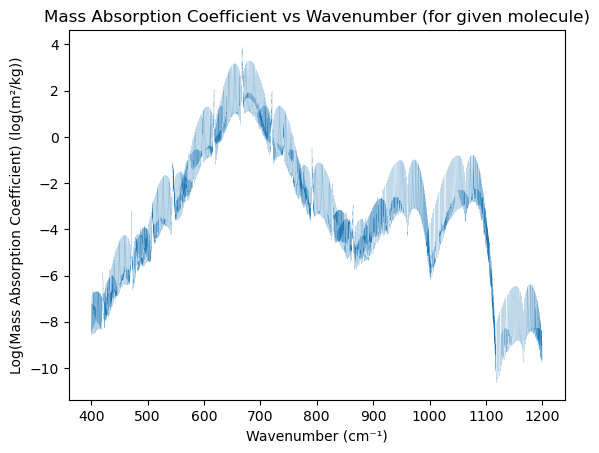

In [85]:
wavenumber_CO2_1, CO2_log_coefs_1 = import_HAPI_data("CO2",2,1, 400, 1200, .04401)

In [89]:
A_train, A_temp, b_train, b_temp = train_test_split(wavenumber_CO2_1, CO2_log_coefs_1,test_size=0.3)
A_val, A_test, b_val, b_test = train_test_split(A_temp, b_temp,test_size=0.66)

# Convert to tensors and reshape (unsqueeze)
A_train = torch.tensor(A_train).float().unsqueeze(1)
b_train =torch.tensor(b_train).float().unsqueeze(1)
A_val = torch.tensor(A_val).float().unsqueeze(1)
b_val = torch.tensor(b_val).float().unsqueeze(1)
A_test = torch.tensor(A_test).float().unsqueeze(1)
b_test = torch.tensor(b_test).float().unsqueeze(1)

# Normalize using training set stats only
A_mean, A_std = A_train.mean(), A_train.std()

A_train = (A_train - A_mean) / A_std
A_val = (A_val - A_mean) / A_std
A_test = (A_test - A_mean) / A_std

In [143]:
#hyperparameter tuning
learningRates = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, .05, .1]
epochs = 1000

optimal_loss_c1 = float('inf') #big intial loss value so it'll update
optimal_hyperparameters_c1 = {}

for lr in learningRates: #for loop for all hyperparameters
        model = SpectralNN() #instance of the neural network class we created above
        loss_function = nn.MSELoss()  #a loss function object using mean square error 
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)   #adam optimizer, combines momentum and RMSProp along with what we assume is gradient descent 

        for epoch in range(1000):
            model.train()  #sets model to training mode, not neccesary for this basic model
            optimizer.zero_grad() #clears out old gradients from last step
            b_pred = model(A_train) #computes predicted values ie forward pass
            loss = loss_function(b_pred, b_train) #computes loss using MSE
            loss.backward() #computes loss gradients for backward pass
            optimizer.step()  #uses backward pass to update model weights

        #validation
        model.eval()
        with torch.no_grad():
            pred_val = model(A_val) #uses model trained to get predicted values
            val_loss1 = loss_function(pred_val, b_val).item() #calculates loss

        print(f"lr: {lr}, epochs: {epochs}, val_loss: {val_loss1:.4f}") #prints it out

        if val_loss1 < optimal_loss_c1:  #updates best loss for final model training
            optimal_loss_c1 = val_loss1
            optimal_hyperparameters_c1 = {'lr': lr, 'epochs': epochs, 'model': model}

print(f"Best val loss: {optimal_loss_c1:.4f} with params: {optimal_hyperparameters_c1}")


lr: 0.0001, epochs: 1000, val_loss: 3.3132
lr: 0.0005, epochs: 1000, val_loss: 1.1459
lr: 0.001, epochs: 1000, val_loss: 0.9844
lr: 0.005, epochs: 1000, val_loss: 0.5046
lr: 0.01, epochs: 1000, val_loss: 0.5143
lr: 0.05, epochs: 1000, val_loss: 0.9884
lr: 0.1, epochs: 1000, val_loss: 0.5238
Best val loss: 0.5046 with params: {'lr': 0.005, 'epochs': 1000, 'model': SpectralNN(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)}


In [147]:
# CO2 model training
CO2_model1 = SpectralNN() #instance of the neural network class we created above
CO2_loss_function1 = nn.MSELoss()  #a loss function object using mean square error 
CO2_optimizer1 = torch.optim.Adam(CO2_model1.parameters(), lr=0.005)   #adam optimizer, combines momentum and RMSProp along with what we assume is gradient descent 

for epoch in range(1000):
    CO2_model1.train()  #sets model to training mode, not neccesary for this basic model

    b_pred1 = CO2_model1(A_train) #computes predicted values ie forward pass
    CO2_loss1 = CO2_loss_function1(b_pred1, b_train) #computes loss using MSE

    CO2_optimizer1.zero_grad() #clears out old gradients from last step
    CO2_loss1.backward() #computes loss gradients for backward pass
    CO2_optimizer1.step()  #uses backward pass to update model weights

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {CO2_loss1.item():.4f}") #prints loss at every 100th epoch

Epoch 0: Loss = 22.1933
Epoch 100: Loss = 1.7625
Epoch 200: Loss = 0.9897
Epoch 300: Loss = 0.6814
Epoch 400: Loss = 0.5757
Epoch 500: Loss = 0.5443
Epoch 600: Loss = 0.5289
Epoch 700: Loss = 0.5229
Epoch 800: Loss = 0.5196
Epoch 900: Loss = 0.5172


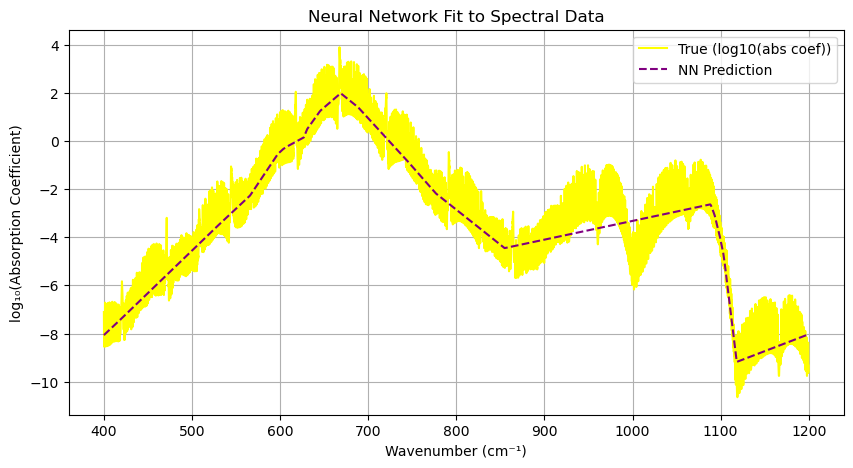

Test Loss (MSE): 0.5404
Test RMSE: 0.7351


In [101]:
CO2_model1.eval()

with torch.no_grad(): #uses torch without gradient since evaluation doesn't need gradients
    b_pred1 = CO2_model1(A_test)  #gets y_pred for comparision

# Convert tensors to NumPy arrays for plotting
A_test_vals1 = (A_test * A_std + A_mean).squeeze().numpy() #converts back to original units
b_test_vals1 = b_test.squeeze().numpy()
b_pred_vals1 = b_pred1.squeeze().numpy()

sorted_indices = A_test_vals1.argsort()
A_test_vals_sorted1 = A_test_vals1[sorted_indices]
b_test_true_sorted1 = b_test_vals1[sorted_indices]
b_pred_vals_sorted1 = b_pred_vals1[sorted_indices]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(A_test_vals_sorted1, b_test_true_sorted1, label='True (log10(abs coef))', color='yellow')
plt.plot(A_test_vals_sorted1, b_pred_vals_sorted1, label='NN Prediction', color='purple', linestyle='--')
plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("log₁₀(Absorption Coefficient)")
plt.title("Neural Network Fit to Spectral Data")
plt.legend()
plt.grid(True)
plt.show()

test_loss = H2O_loss_function(b_pred1, b_test)  # compute MSE and RMSE for reference
print(f"Test Loss (MSE): {test_loss.item():.4f}")
test_rmse = torch.sqrt(test_loss)
print(f"Test RMSE: {test_rmse.item():.4f}")

Using data

CO2
                     Lines parsed: 35010
H2O
                     Lines parsed: 23399

Data is fetched from http://hitran.org

BEGIN DOWNLOAD: CO2
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes writ

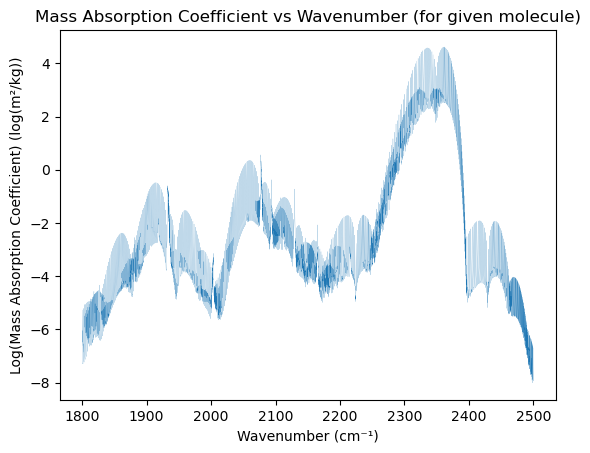

In [115]:
wavenumber_CO2_2, CO2_log_coefs_2 = import_HAPI_data("CO2",2,1, 1800, 2500, .04401)

In [117]:
A_train2, A_temp2, b_train2, b_temp2 = train_test_split(wavenumber_CO2_2, CO2_log_coefs_2,test_size=0.3)
A_val2, A_test2, b_val2, b_test2 = train_test_split(A_temp2, b_temp2, test_size=0.66)

# Convert to tensors and reshape (unsqueeze)
A_train2 = torch.tensor(A_train2).float().unsqueeze(1)
b_train2 =torch.tensor(b_train2).float().unsqueeze(1)
A_val2 = torch.tensor(A_val2).float().unsqueeze(1)
b_val2 = torch.tensor(b_val2).float().unsqueeze(1)
A_test2 = torch.tensor(A_test2).float().unsqueeze(1)
b_test2 = torch.tensor(b_test2).float().unsqueeze(1)

# Normalize using training set stats only
A_mean2, A_std2 = A_train2.mean(), A_train2.std()

A_train2 = (A_train2 - A_mean2) / A_std2
A_val2 = (A_val2 - A_mean2) / A_std2
A_test2 = (A_test2 - A_mean2) / A_std2

In [131]:
#hyperparameter tuning
learningRates = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, .05, .1]
epochs = 1000

optimal_loss_c2 = float('inf') #big intial loss value so it'll update
optimal_hyperparameters_c2 = {}

for lr in learningRates: #for loop for all hyperparameters
        model = SpectralNN() #instance of the neural network class we created above
        loss_function = nn.MSELoss()  #a loss function object using mean square error 
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)   #adam optimizer, combines momentum and RMSProp along with what we assume is gradient descent 

        for epoch in range(1000):
            model.train()  #sets model to training mode, not neccesary for this basic model
            optimizer.zero_grad() #clears out old gradients from last step
            b_pred2 = model(A_train2) #computes predicted values ie forward pass
            loss = loss_function(b_pred2, b_train2) #computes loss using MSE
            loss.backward() #computes loss gradients for backward pass
            optimizer.step()  #uses backward pass to update model weights

        #validation
        model.eval()
        with torch.no_grad():
            pred_val2 = model(A_val2) #uses model trained to get predicted values
            val_loss2 = loss_function(pred_val2, b_val2).item() #calculates loss

        print(f"lr: {lr}, epochs: {epochs}, val_loss: {val_loss2:.4f}") #prints it out

        if val_loss2 < optimal_loss_c2:  #updates best loss for final model training
            optimal_loss_c2 = val_loss2
            optimal_hyperparameters_c2 = {'lr': lr, 'epochs': epochs, 'model': model}

print(f"Best val loss: {optimal_loss_c2:.4f} with params: {optimal_hyperparameters_c2}")


lr: 0.0001, epochs: 1000, val_loss: 4.2166
lr: 0.0005, epochs: 1000, val_loss: 1.0756
lr: 0.001, epochs: 1000, val_loss: 0.9954
lr: 0.005, epochs: 1000, val_loss: 0.7471
lr: 0.01, epochs: 1000, val_loss: 0.3660
lr: 0.05, epochs: 1000, val_loss: 0.4671
lr: 0.1, epochs: 1000, val_loss: 0.3646
Best val loss: 0.3646 with params: {'lr': 0.1, 'epochs': 1000, 'model': SpectralNN(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)}


In [137]:
# CO2 model training
CO2_model2 = SpectralNN() #instance of the neural network class we created above
CO2_loss_function2 = nn.MSELoss()  #a loss function object using mean square error 
CO2_optimizer2 = torch.optim.Adam(CO2_model2.parameters(), lr=0.1)   #adam optimizer, combines momentum and RMSProp along with what we assume is gradient descent 

for epoch in range(1000):
    CO2_model2.train()  #sets model to training mode, not neccesary for this basic model

    b_pred2 = CO2_model2(A_train2) #computes predicted values ie forward pass
    CO2_loss2 = CO2_loss_function2(b_pred2, b_train2) #computes loss using MSE

    CO2_optimizer2.zero_grad() #clears out old gradients from last step
    CO2_loss2.backward() #computes loss gradients for backward pass
    CO2_optimizer2.step()  #uses backward pass to update model weights

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {CO2_loss2.item():.4f}") #prints loss at every 100th epoch

Epoch 0: Loss = 13.8377
Epoch 100: Loss = 0.8317
Epoch 200: Loss = 0.5086
Epoch 300: Loss = 0.4267
Epoch 400: Loss = 0.3983
Epoch 500: Loss = 0.4001
Epoch 600: Loss = 0.4014
Epoch 700: Loss = 0.3647
Epoch 800: Loss = 0.3802
Epoch 900: Loss = 0.3571


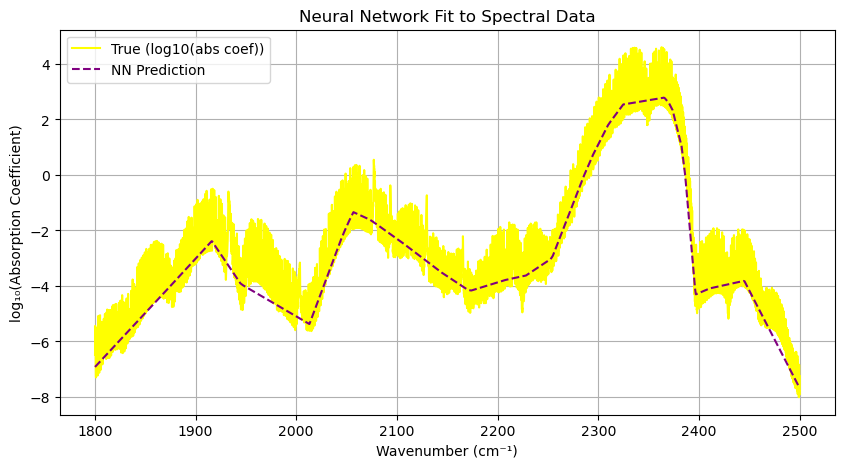

Test Loss (MSE): 0.4473
Test RMSE: 0.6688


In [149]:
CO2_model2.eval()

with torch.no_grad(): #uses torch without gradient since evaluation doesn't need gradients
    b_pred2 = CO2_model2(A_test2)  #gets y_pred for comparision

# Convert tensors to NumPy arrays for plotting
A_test_vals2 = (A_test2 * A_std2 + A_mean2).squeeze().numpy() #converts back to original units
b_test_vals2 = b_test2.squeeze().numpy()
b_pred_vals2 = b_pred2.squeeze().numpy()

sorted_indices = A_test_vals2.argsort()
A_test_vals_sorted2 = A_test_vals2[sorted_indices]
b_test_true_sorted2 = b_test_vals2[sorted_indices]
b_pred_vals_sorted2 = b_pred_vals2[sorted_indices]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(A_test_vals_sorted2, b_test_true_sorted2, label='True (log10(abs coef))', color='yellow')
plt.plot(A_test_vals_sorted2, b_pred_vals_sorted2, label='NN Prediction', color='purple', linestyle='--')
plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("log₁₀(Absorption Coefficient)")
plt.title("Neural Network Fit to Spectral Data")
plt.legend()
plt.grid(True)
plt.show()

test_loss2 = H2O_loss_function(b_pred2, b_test2)  # compute MSE and RMSE for reference
print(f"Test Loss (MSE): {test_loss2.item():.4f}")
test_rmse2 = torch.sqrt(test_loss2)
print(f"Test RMSE: {test_rmse2.item():.4f}")

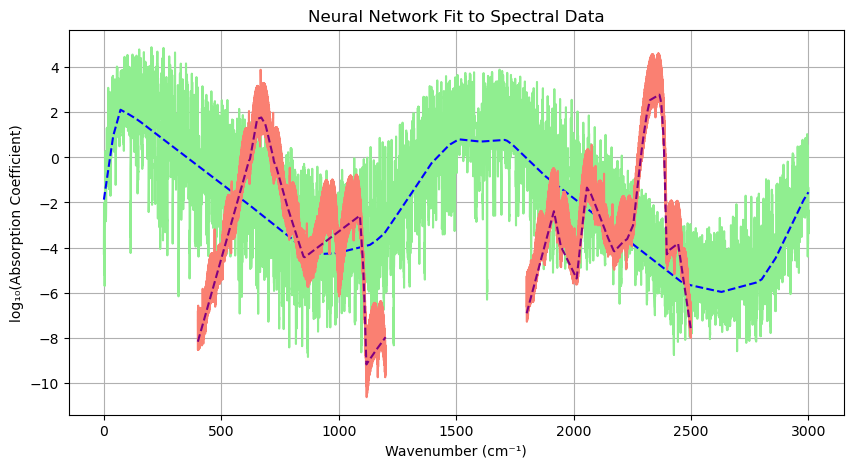

In [153]:
#overlaying all plots
plt.figure(figsize=(10, 5))
plt.plot(wavenumber_H2O, H2O_log_coefs, label='True (log10(abs coef))', color='lightgreen')
plt.plot(X_test_vals_sorted, y_pred_vals_sorted, label='NN Prediction', color='blue', linestyle='--')

plt.plot(wavenumber_CO2_1, CO2_log_coefs_1, label='True (log10(abs coef))', color='salmon')
plt.plot(A_test_vals_sorted1, b_pred_vals_sorted1, label='NN Prediction', color='purple', linestyle='--')

plt.plot(wavenumber_CO2_2, CO2_log_coefs_2, label='True (log10(abs coef))', color='salmon')
plt.plot(A_test_vals_sorted2, b_pred_vals_sorted2, label='NN Prediction', color='purple', linestyle='--')
plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("log₁₀(Absorption Coefficient)")
plt.title("Neural Network Fit to Spectral Data")
plt.grid(True)
plt.show()

In [177]:
#here's an example of how to input any wavenumber and then retrieve the neural networks prediction
#the below achieves the greatest absoprtion coeffcient at a specific wavenumber
input_wn = 800

# Step 1: Convert to tensor and reshape
X_test = torch.tensor([[(input_wn - x_mean) / x_std]], dtype=torch.float32).unsqueeze(0)

a1_test = torch.tensor([[(input_wn - A_mean) / A_std]], dtype=torch.float32).unsqueeze(0)
a2_test = torch.tensor([[(input_wn - A_mean2) / A_std2]], dtype=torch.float32).unsqueeze(0)

# Step 2: Use the model to predict
H2O_model1.eval()  # set model to evaluation mode (no dropout, no gradient tracking)
CO2_model1.eval()
CO2_model2.eval()

with torch.no_grad():  # don't compute gradients for inference
    y_pred_f = H2O_model1(X_test).item()  # NN predicts log10(absorption coefficient)
result = y_pred_f

if input_wn > 400 and input_wn < 1200:
    with torch.no_grad():  # don't compute gradients for inference
        b_pred1f = CO2_model1(a1_test).item()  # NN predicts log10(absorption coefficient)
    if y_pred_f <= b_pred1f:
        result = b_pred1f

if input_wn > 1800 and input_wn < 2500:
    with torch.no_grad():  # don't compute gradients for inference
        b_pred2f = CO2_model2(a2_test2).item()  # NN predicts log10(absorption coefficient)
        if y_pred_f <= b2_pred2f:
            result = b2_pred2f

# Step 4: Print results
print(f"\nPrediction for wavenumber {input_wn} cm⁻¹:")
print(f"  Absorption Coefficient (log10 form) (m²/kg) = {result}")
real_result = 10**result
print(f"  Absorption Coefficient (original form) (m²/kg) = {real_result}")


Prediction for wavenumber 800 cm⁻¹:
  Absorption Coefficient (log10 form) (m²/kg) = -2.8784828186035156
  Absorption Coefficient (original form) (m²/kg) = 0.0013228700418664453


In [179]:
#creating data files
import pandas as pd

h2o_df = pd.DataFrame({'wavenumber_cm^-1': wavenumber_H2O, 'absorption_coef': H2O_log_coefs})
h2o_df.to_csv('h2o_absorption_wn0-3000_260K_500hPa.csv', index=False)

co2_df1 = pd.DataFrame({'wavenumber_cm^-1': wavenumber_CO2_1, 'absorption_coef': CO2_log_coefs_1})
co2_df1.to_csv('co2_absorption_wn400-1200_260K_500hPa.csv', index=False)

co2_df2 = pd.DataFrame({'wavenumber_cm^-1': wavenumber_CO2_2, 'absorption_coef': CO2_log_coefs_2})
co2_df2.to_csv('h2o_absorption_wn1800-2500_260K_500hPa.csv', index=False)